In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


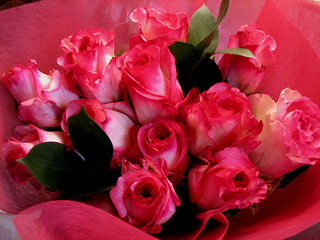

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

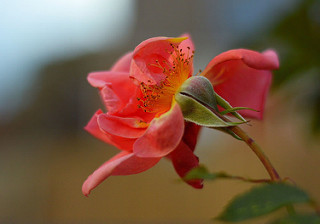

In [6]:
PIL.Image.open(str(roses[1]))

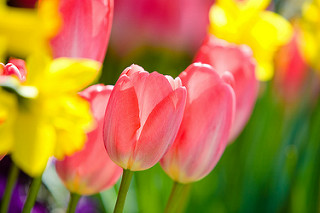

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

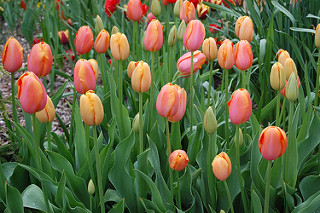

In [9]:
PIL.Image.open(str(tulips[5]))

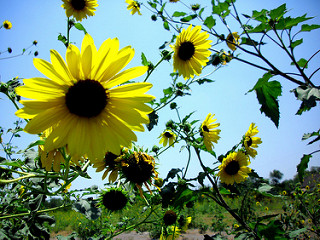

In [11]:
#exploring the other type of flowers in the flowers_photos directory:

sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[1])) #sunflower image

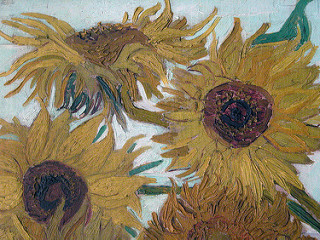

In [12]:
PIL.Image.open(str(sunflowers[8]))

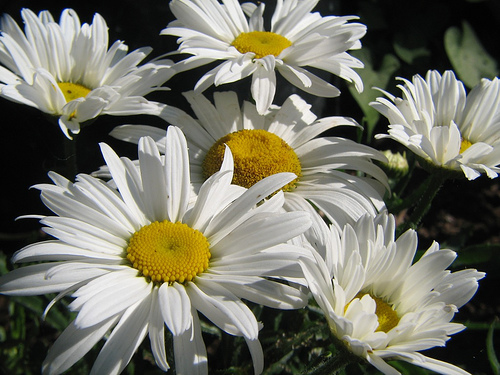

In [14]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[4]))

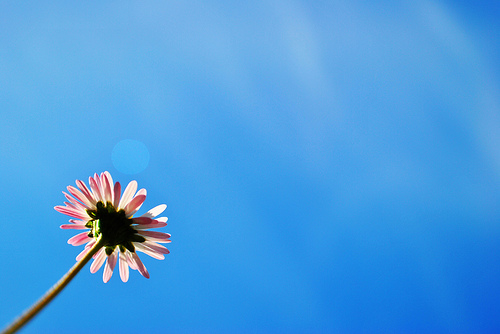

In [15]:
PIL.Image.open(daisy[15])

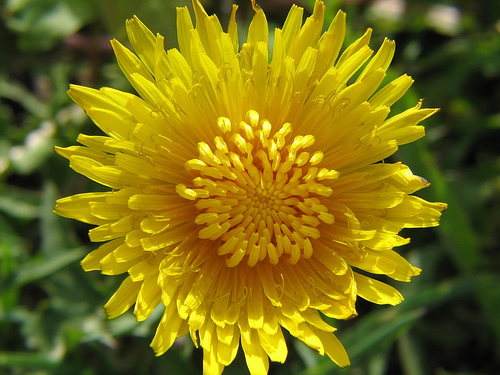

In [16]:
dandelion = list(data_dir.glob('dandelion/*'))
PIL.Image.open(dandelion[7])

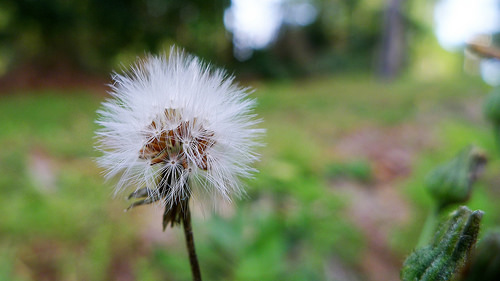

In [17]:
PIL.Image.open(dandelion[90])

In [18]:
#### Load using keras.preprocessing

In [19]:
batch_size = 35
img_height = 200
img_width = 200

In [21]:
####validation split

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [23]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [26]:
####print class_names

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [27]:
#### visualization of data

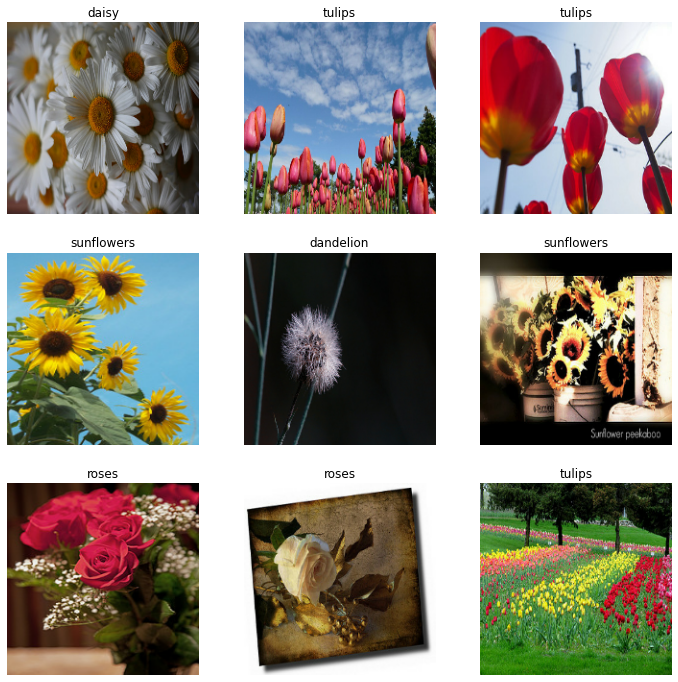

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [32]:
for images_batch, labels_batch in train_ds:
  print(images_batch.shape)
  print(labels_batch.shape)
  break

(35, 200, 200, 3)
(35,)


In [33]:
#### configuring the dataset for performance

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

In [35]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [36]:
####standardize the data

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [37]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9998824


In [38]:
####creating the model

In [39]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
#### compiling the model

In [42]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
###model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0

In [44]:
#### training the model

epochs = 10
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = epochs)

Epoch 1/10
84/84 [==============================] - 94s 1s/step - loss: 1.6517 - accuracy: 0.3132 - val_loss: 1.0745 - val_accuracy: 0.5545
Epoch 2/10
84/84 [==============================] - 92s 1s/step - loss: 1.0121 - accuracy: 0.6014 - val_loss: 1.0538 - val_accuracy: 0.5681
Epoch 3/10
84/84 [==============================] - 92s 1s/step - loss: 0.8452 - accuracy: 0.6754 - val_loss: 0.9093 - val_accuracy: 0.6485
Epoch 4/10
84/84 [==============================] - 93s 1s/step - loss: 0.6127 - accuracy: 0.7728 - val_loss: 1.0489 - val_accuracy: 0.5913
Epoch 5/10
84/84 [==============================] - 93s 1s/step - loss: 0.3697 - accuracy: 0.8719 - val_loss: 1.0501 - val_accuracy: 0.6444
Epoch 6/10
84/84 [==============================] - 93s 1s/step - loss: 0.2268 - accuracy: 0.9195 - val_loss: 1.2556 - val_accuracy: 0.6499
Epoch 7/10
84/84 [==============================] - 92s 1s/step - loss: 0.1319 - accuracy: 0.9615 - val_loss: 1.3333 - val_accuracy: 0.6376
Epoch 8/10
84/84 [==

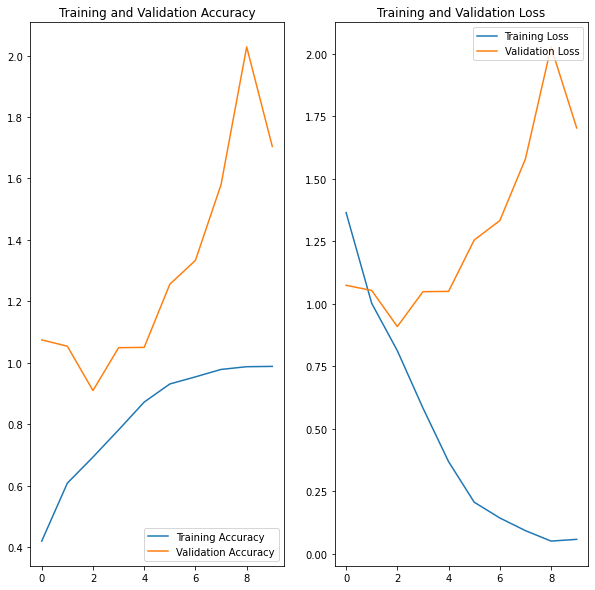

In [46]:
#### visualize training results

acc = history.history['accuracy']
cal_acc = history.history['val_accuracy']

loss = history.history['loss']
val_acc = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
#### Data augmentation

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

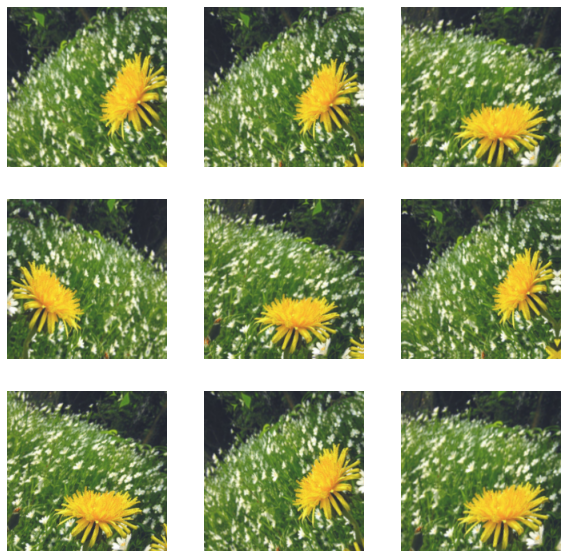

In [48]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [49]:
#### Dropout

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [50]:
#### compile and train the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)       

In [52]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
84/84 [==============================] - 110s 1s/step - loss: 1.5280 - accuracy: 0.3450 - val_loss: 1.0883 - val_accuracy: 0.5599
Epoch 2/15
84/84 [==============================] - 109s 1s/step - loss: 1.0749 - accuracy: 0.5812 - val_loss: 1.0125 - val_accuracy: 0.6022
Epoch 3/15
84/84 [==============================] - 109s 1s/step - loss: 0.9572 - accuracy: 0.6266 - val_loss: 0.9638 - val_accuracy: 0.6322
Epoch 4/15
84/84 [==============================] - 109s 1s/step - loss: 0.8991 - accuracy: 0.6467 - val_loss: 0.8859 - val_accuracy: 0.6580
Epoch 5/15
84/84 [==============================] - 109s 1s/step - loss: 0.8235 - accuracy: 0.6885 - val_loss: 0.8524 - val_accuracy: 0.6744
Epoch 6/15
84/84 [==============================] - 110s 1s/step - loss: 0.7691 - accuracy: 0.6961 - val_loss: 0.7948 - val_accuracy: 0.7166
Epoch 7/15
84/84 [==============================] - 109s 1s/step - loss: 0.7219 - accuracy: 0.7148 - val_loss: 0.7620 - val_accuracy: 0.6989
Epoch 8/15
84

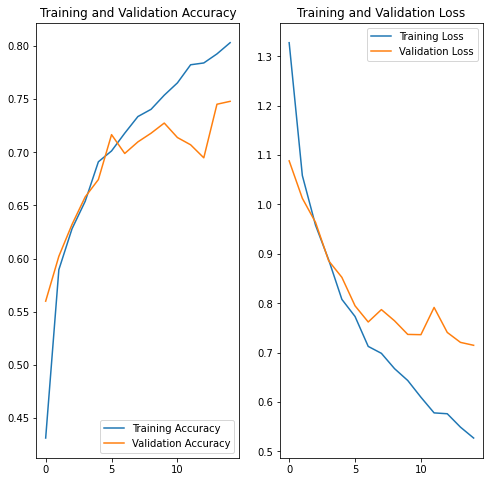

In [53]:
#### visualize training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
#### Predicting on new data

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 99.07 percent confidence.
